In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display #lets you show more than one df
import os
import multiprocessing as mp
import gc


In [30]:
#configure this string as the directory to where you have the files.
dataDir = '/home/ubuntu/LCPB/data/'


## Data Structure

#### Folder set 1, f_MT: accretion efficiency (the fraction of mass lost from a primary star that can be accreted by a secondary star during a mass transfer episode).

In [31]:
f_MT= [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
0.95, 1]
#create same label as data
f_MT_lb = [str(x).replace('.', '') for x in f_MT]# lb for label

#### Sub folder, Alpha: common envelope efficiency

In [32]:
alpha = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
alpha_lb = [str(x) for x in alpha]

#### Files, split by  
data_BHBs_$*$.txt → files corresponding to binary black holes (BHBs)  
data_BHNS_$*$.txt → files corresponding to black hole – neutron star binaries 

$*$ indicates 12 different metallicities (Z) of the stellar progenitors of the binary compact objects.


In [33]:
#Metalicity
Z = [0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016, 0.02]
Z_lb = [str(x) for x in Z]

#### Data 

* Column 0: identifier of the binary  
* Column 1: initial mass (ZAMS mass) of the primary member of the binary system in Msun (1 Msun= 1.989e33 g). This is the initial mass of the most massive stellar progenitor.  
* Column 2: initial mass (ZAMS mass) of the secondary member of the binarysystem in Msun. This is the initial mass of the least massive stellar progenitor.    
* Column 3: mass of the compact object that forms from the primary member
(Msun)  
* Column 4: mass of the compact object that forms from the secondary member
(Msun)  
* Column 5: mass of the merger remnant of the two compact objects (Msun). In these simulations, it is just the sum of the masses of the two compact objects.
* Column 6: delay time, i.e. time elapsed from the formation of the binary system to the merger of the two compact objects (in Gyr = 1e9 yr)
* Column 7: semi-major axis of the binary system at the formation of the second-born compact object (in solar radii, Rsun = 6.96e10 cm)
* Column 8: orbital eccentricity of the binary system at the formation of the second-born compact object.

## Insert parquet code
include the code jake used to make the parquete data file and explain the optimisation this achieved and the reasons is was necessary. Postentially briefly explain the other options considered, dask, spark, chunking.

In [34]:
#unit dictionary
units = {
    'ZAMS' : 'Msun',
    'comp' : 'Msun',
    'merge' : 'Msun',
    't_delay' : 'Gyr',
    'smj_axis' : 'Rsun',
}

#you must select desired columns using the column names in a list. 
#you can take a random subset by selecting the number of BBH you want or the fraction of the total data
#set the default directory to where you have the parquet file
def getData(col = ['m_ZAMS_1', 'm_ZMAS_2', 'm_comp_1', 'm_comp_2', 'm_merge', 't_delay', 'smj_axis', 'alpha', 'f_MT', 'Z','orb_ecc']
            , rRows = 0, dataFraction = 1, dataDir = '~/LCPB/all_BHBs.parquet',seed = None):
    if (dataFraction != 1):
        rRows = int(dataFraction*87756770)
    if (rRows == 0):
        return pd.read_parquet(dataDir, columns = col)
    elif (rRows > 0):
        rand = np.random.default_rng(seed = seed)
        rows_selected = rand.integers(low = 0, high = 87756770, size = rRows)
        concf = pd.DataFrame()
        for col_i in col:
            onecol = pd.read_parquet(dataDir, columns = [col_i]).iloc[rows_selected]
            concf = pd.concat([concf, onecol], axis=1)
            del(onecol)
            gc.collect()
        return concf

#examples
#df = getData(dataFraction=0.1,seed = 12345) #returns all columns but only a random 10% of the rows, with an inputted seed.
#df2 = getData(col = ['m_ZAMS_1','m_ZAMS_2','orb_ecc','m_merge','t_delay'],rRows=5)#returns two selected colums and only 5 random binary systems

In [11]:
df2

,m_ZAMS_1,m_ZAMS_2,orb_ecc,m_merge,t_delay
20028283,60.1543,35.4132,0.009943,50.2874,0.680347
43232103,29.7273,19.9895,0.388070,13.8523,0.179178
83544197,78.4485,27.9013,0.013971,35.7886,2.179679
26421192,32.7079,23.3518,0.116040,19.5380,1.543228
11713280,61.0003,56.2363,0.029413,60.0301,12.994685


In [35]:
def plotMedian(df,prop):
    def lowerQuartile(stuff):
        return np.quantile(stuff,0.25)
    def upperQuartile(stuff):
        return np.quantile(stuff,0.75)

    med = df.groupby(prop)['t_delay'].agg('median').reset_index()
    lq = df.groupby(prop)['t_delay'].agg(lowerQuartile).reset_index()
    uq = df.groupby(prop)['t_delay'].agg(upperQuartile).reset_index()
    med.columns = [prop, 'median_t_delay']

    med['lower_quartile'] = lq['t_delay']
    med['upper_quartile'] = uq['t_delay']
    figAcc = plt.figure()
    plt.plot(med[prop],med['median_t_delay'],label = 'Median')
    plt.xlabel(prop)
    plt.ylabel('Time Delay '+units['t_delay'])
    plt.title('Binary Black Hole Systems')
    plt.fill_between(med[prop], med['lower_quartile'], med['upper_quartile'], alpha=0.4, color='darkorange',label = 'Interquartile Range')
    plt.legend()
    return med

(array([36825678., 12026037.,  8329703.,  6571907.,  5443501.,  4644765.,
         4064197.,  3616473.,  3260779.,  2973730.]),
 array([4.57320000e-03, 1.40411578e+00, 2.80365836e+00, 4.20320094e+00,
        5.60274352e+00, 7.00228610e+00, 8.40182868e+00, 9.80137126e+00,
        1.12009138e+01, 1.26004564e+01, 1.39999990e+01]),
 <BarContainer object of 10 artists>)

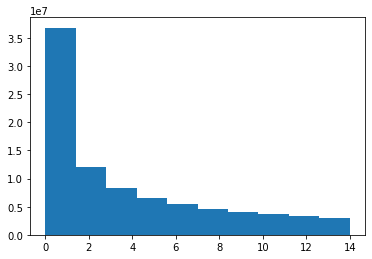

In [14]:
t_delay = getData(col = ['t_delay'])
plt.hist(t_delay)

# Accretion Efficiancy

,Accretion Efficiency,median_t_delay,lower_quartile,upper_quartile
0,0.05,1.995949,0.467149,5.782688
1,0.1,1.991633,0.462488,5.803127
2,0.15,2.008681,0.457542,5.932697
3,0.2,2.136145,0.470302,6.228651
4,0.25,2.278570,0.487686,6.473514
5,0.3,2.376820,0.502852,6.590277
6,0.35,2.405806,0.508072,6.618817
7,0.4,2.433011,0.512004,6.682508
8,0.45,2.435796,0.505968,6.669694
9,0.5,2.421610,0.498481,6.611126


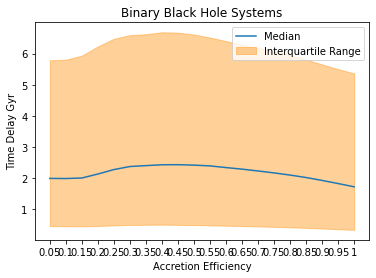

In [18]:
# Accretion Efficiency f_MT, getting the data
df = getData(col = ['f_MT','t_delay'])
df = df.rename(columns = {'f_MT':'Accretion Efficiency'})
median = plotMedian(df,'Accretion Efficiency')
median

# Common Envalope Efficiancy

,Common Envalope Efficiancy,median_t_delay,lower_quartile,upper_quartile
0,0.5,0.146489,0.035110,1.266774
1,1,0.466766,0.085272,2.125355
2,2,0.992626,0.198484,4.162977
3,3,1.572296,0.395511,4.930109
4,4,2.381117,0.709667,6.082266
5,5,3.195379,1.113011,7.071482
6,6,3.903664,1.550487,7.812633
7,7,4.540015,2.012089,8.356999
8,8,5.096031,2.475868,8.827353
9,9,5.572452,2.898868,9.206837


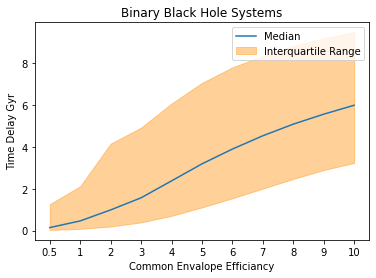

In [19]:
df = getData(col = ['alpha','t_delay'])
df = df.rename(columns = {'alpha':'Common Envalope Efficiancy'})
median = plotMedian(df,'Common Envalope Efficiancy')
median

# Metalicity

,Metalicity,median_t_delay,lower_quartile,upper_quartile
0,0.0002,1.741538,0.380066,5.160981
1,0.0004,1.991383,0.422104,5.630425
2,0.0008,2.352511,0.479996,6.389658
3,0.0012,2.451532,0.486995,6.674580
4,0.0016,2.401452,0.449581,6.677773
5,0.002,2.361548,0.453396,6.646560
6,0.004,2.935813,0.590829,7.698203
7,0.006,2.528598,0.668609,7.245487
8,0.008,2.482135,0.612524,6.253724
9,0.012,4.694326,1.376787,8.645225


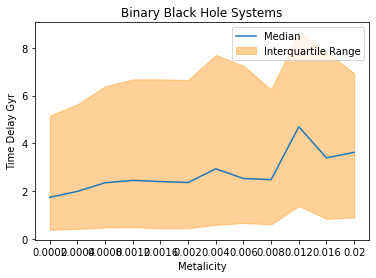

In [20]:
df = getData(col = ['Z','t_delay'])
df = df.rename(columns = {'Z':'Metalicity'})
median = plotMedian(df,'Metalicity')
median

## Mass of Merger Remenant

In [36]:
df = getData(col = ['m_merge','t_delay'])

In [41]:
qlbl = [str(a) for a in list(range(0,50))]
df['quantile'] = pd.qcut(df['m_merge'], q = 50, labels = qlbl)
df

,m_merge,t_delay,quantile
0,42.5542,0.008093,41
1,46.6264,0.010175,43
2,72.3740,0.272228,48
3,48.8107,0.008453,43
4,40.2339,0.044590,39
...,...,...,...
87756765,7.9272,0.006562,1
87756766,13.2829,1.176829,13
87756767,8.7815,0.712588,3
87756768,7.5895,1.782024,1


,quantile,median_t_delay,lower_quartile,upper_quartile
0,0,3.393305,1.252717,7.215657
1,1,3.016974,1.026061,6.862935
2,2,2.808872,0.897072,6.663686
3,3,2.651874,0.804213,6.484290
4,4,2.509877,0.726195,6.326734
5,5,2.392532,0.668516,6.182104
6,6,2.297936,0.621980,6.065274
7,7,2.195226,0.576469,5.934312
8,8,2.111801,0.537681,5.824092
9,9,2.023859,0.492917,5.713274


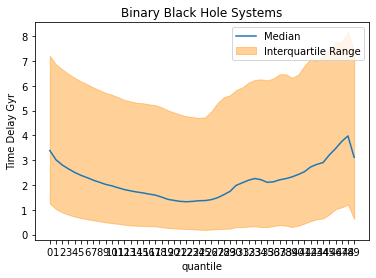

In [42]:
plotMedian(df,'quantile')

(array([27987205., 17766772., 12692635., 12044683.,  6680024.,  3997124.,
         2706505.,  2003224.,  1277488.,   601110.]),
 array([ 6.0018 , 14.63782, 23.27384, 31.90986, 40.54588, 49.1819 ,
        57.81792, 66.45394, 75.08996, 83.72598, 92.362  ]),
 <BarContainer object of 10 artists>)

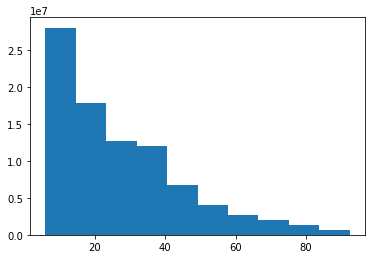

In [24]:
plt.hist(df['m_merge'])

In [21]:
df

,m_merge,t_delay
0,42.5542,0.008093
1,46.6264,0.010175
2,72.3740,0.272228
3,48.8107,0.008453
4,40.2339,0.044590
...,...,...
87756765,7.9272,0.006562
87756766,13.2829,1.176829
87756767,8.7815,0.712588
87756768,7.5895,1.782024
